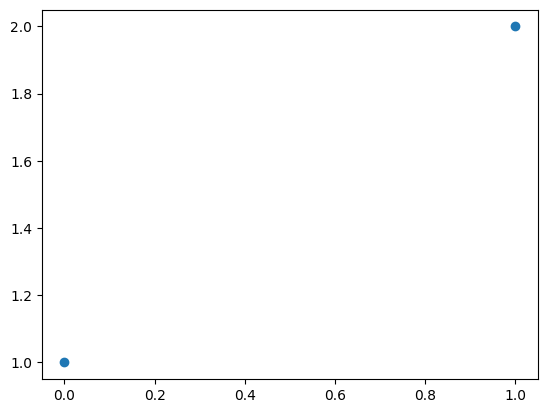

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [5]:
importlib.reload(kgs)
data=kgs.load_all_train_data(validation_only=True)
print(len(data))
for d in data:
    d.check_constraints()
import seis_nn
model = seis_nn.default_pretrained
model.batch_size = 1
data = model.infer(data)

5000


Importing cache brendan: 100%|████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 217.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 569.76it/s]


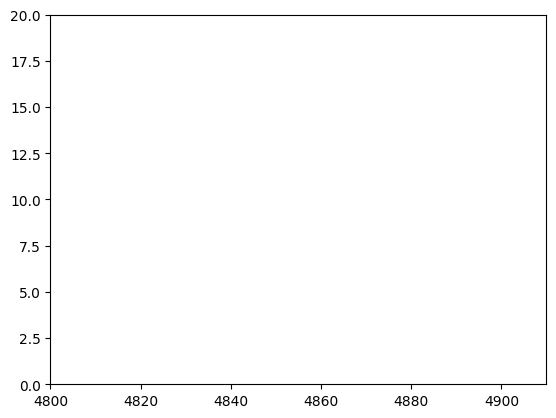

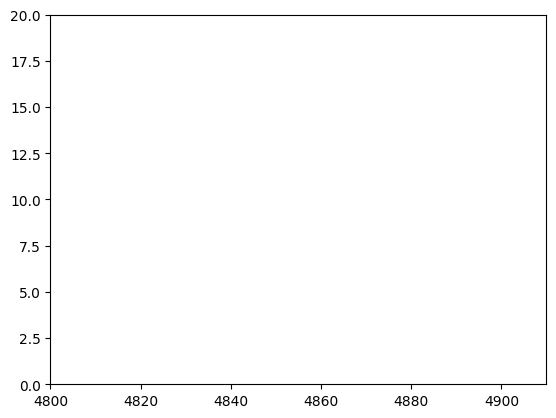

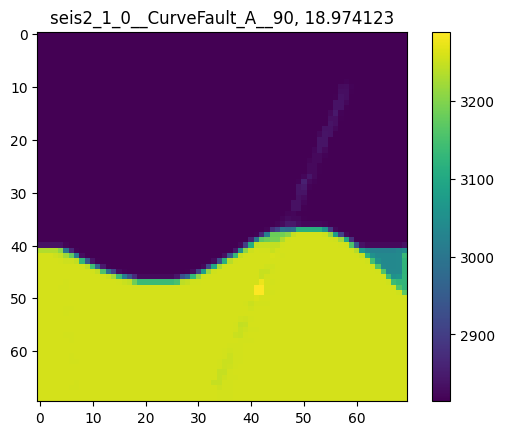

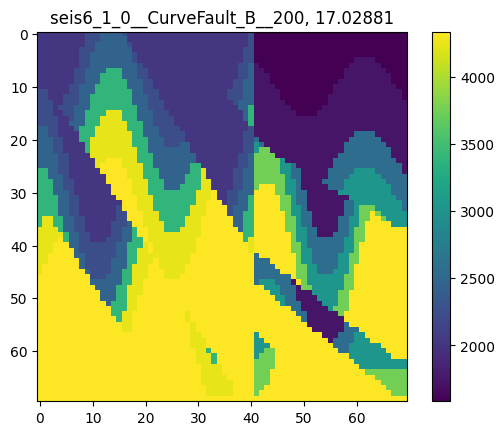

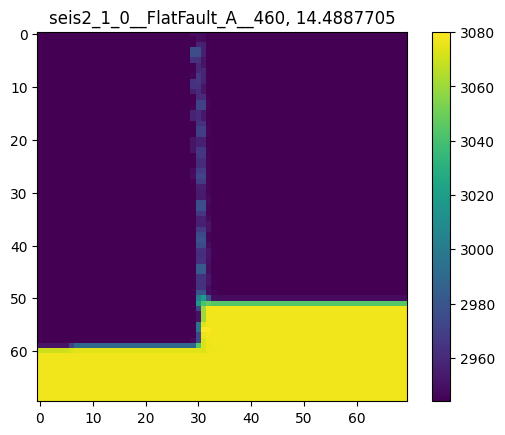

In [83]:
vals_not = []
vals_styleA = []
vals_styleB = []
#import seis_prior
#import seis_model
# prior = seis_model.default_model().models[1].model_Style_B.prior
# prior.transform = False
# prior.prepped = False
# prior.prep()
def kpi_style_B(vel):
    import cupyx.scipy.ndimage
    max_filtered = cupyx.scipy.ndimage.maximum_filter(vel, 10)
    vals = cp.abs(vel-max_filtered).flatten()
    #vals=vel.flatten()
    vals=cp.diff(cp.sort(vals))
    vals=cp.sort(vals)
    #vals=vals/cp.mean(vals)
    #kpi=cp.log(cp.mean(vals**10))
    #return cp.max(cp.abs(vals)).get()
    #plt.plot(vals.flatten().get());
    #print(vals[-1])
    return cp.log(cp.max(vals)).get()
plt.figure();
for d in data[0:3000][::10]:
    d.velocity.load_to_memory()
    kpi_style_B(d.velocity.data)
plt.xlim([4800,4910])
plt.ylim([0,20])
plt.figure();
for d in data[4500:][::10]:
    d.velocity.load_to_memory()
    kpi_style_B(d.velocity.data)
plt.xlim([4800,4910])
plt.ylim([0,20])

from tqdm import tqdm
import cupy as cp
for d in tqdm(data[::10]):
    if 'FlatVel' in d.family or 'Style_A' in d.family:
        continue # done already
    d.velocity.load_to_memory()
    #d = model.infer([d])[0]
    d.velocity_guess.to_cupy()
    #x = d.velocity_guess.to_vector()        
    kpi = kpi_style_B(d.velocity_guess.data)#np.log(cp.asnumpy(x[:-1,:].T@(prior.P)@x[:-1,:])[0,0])
    #kpi = cp.asnumpy(kgs.rms(d.seismogram.data[0,...] - cp.flip(d.seismogram.data[4,...],axis=1)))
    if 'Style_B' in d.family:
        vals_styleB.append(kpi)
    else:
        vals_not .append(kpi)       
        if kpi<3.:
            plt.figure();plt.imshow(d.velocity.data.get());plt.colorbar();plt.title(d.cache_name()+', '+str(np.exp(kpi)))
    d.unload()

(350, 2.673374, 2.8021166)

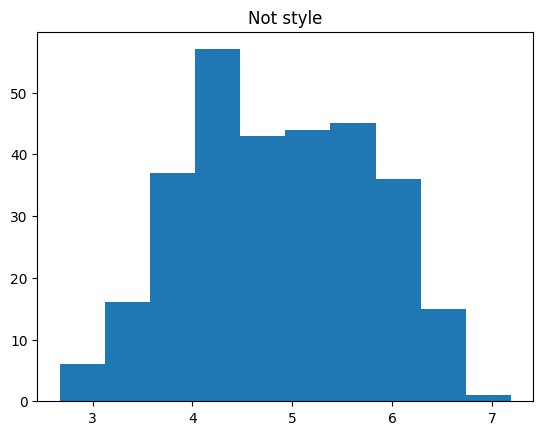

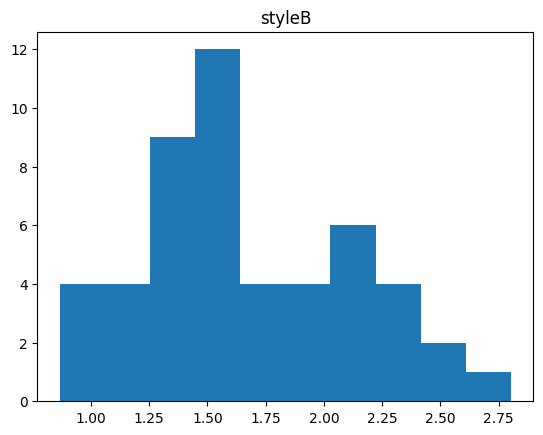

In [80]:
plt.figure()
plt.hist(vals_not)
plt.title('Not style')
plt.figure()
plt.hist(vals_styleB)
plt.title('styleB')
len(vals_not)+len(vals_styleB), np.min(vals_not), np.max(vals_styleB)